In [1]:
import sys
sys.path.append('/home2/jupyter-s.kim/.local/lib/python3.7/site-packages/') # jupyter와 같은 package를 사용하기 위한 경로

### import library

In [2]:
### default
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import random
import time
import copy
from datetime import datetime
from scipy.interpolate import CubicSpline

### modeling
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tensorflow.keras.utils import to_categorical

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

### visualization
import seaborn as sns
from matplotlib import pyplot as plt

### 파라미터 세팅

In [3]:
# 센서 종류
sensors = ['C7H8', 'TMA', 'VOC', 'CO2', 'HCHO', 'H2S', 'NH3', 'CH3SH', 'SO2', 'NO2', 'CO']
cols = ['C7H8', 'TMA', 'VOC', 'CO2', 'HCHO', 'H2S', 'NH3', 'CH3SH', 'SO2', 'NO2', 'CO', 'reg_date', 'label_type']

NUM_CLASSES = 6
RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

### 데이터 불러오기, 학습/검증 데이터로 구분

In [4]:
# df = pd.read_csv('df_type_total_230403.csv') # 3~7차 데이터셋
df = pd.read_csv('df_type_total_230407.csv') # 3~9차 데이터셋
df = df[cols]

In [5]:
df_train = df[pd.to_datetime(df['reg_date']) <= datetime(2023,4,1)]
df_test = df[pd.to_datetime(df['reg_date']) > datetime(2023,4,1)]

In [6]:
len(df), len(df_train), len(df_test)

(11627, 6531, 5096)

In [7]:
df_test['label_type'].value_counts()

B     2640
ME    2456
Name: label_type, dtype: int64

### 함수정의

#### data processing / plotting

In [8]:
# 데이터셋을 만들기 위한 실험 구분
def create_experiment_number(data):
    data['lagged'] = data['reg_date'].shift(-1)
    data['reg_date'] = pd.to_datetime(data['reg_date'])
    data['lagged'] = pd.to_datetime(data['lagged'])
    data['diff'] = data['lagged'] - data['reg_date']
    data['diff'] = data['diff'] /  pd.Timedelta('1s')
    data['diff'].fillna(1,inplace=True) #마지막줄 채워주기 위함
    data.reset_index(drop=True, inplace=True)

    num = 0
    for i in range(len(data)):
        if data.loc[i,'diff'] in [1,2]:
            data.loc[i,'exp_num'] = num
        else:
            data.loc[i,'exp_num'] = num
            num+=1
    data.drop(['lagged','diff'], axis='columns', inplace=True)
    return data

# 실험 별로 시계열 데이터셋을 만들기 위한 함수
def create_windows(data, window_size=5):
    X = []
    y = []
    for num, group_df in data.groupby('exp_num'):
        data = group_df.iloc[:, 0:11].values
        labels = group_df['label_type'].values
        for i in range(len(data) - window_size + 1):
            X.append(data[i:i+window_size])
            y.append(labels[window_size-1])

    return np.array(X), np.array(y)

# 데이터셋을 train/valid/test로 나누는 함수
def split_data(X, y, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1):
    assert train_ratio + val_ratio + test_ratio == 1, "The sum of the ratios must be equal to 1."
    assert len(X) == len(y), "The length of X and y must be the same."
    
    # numpy 배열을 torch 텐서로 변환합니다.
    X = torch.from_numpy(X)
    y = torch.from_numpy(y)

    # 데이터를 무작위로 섞기 위한 인덱스를 생성합니다.
    shuffled_indices = torch.randperm(len(X))

    # 비율에 따라 인덱스를 설정합니다.
    train_cnt = int(len(X) * train_ratio)
    val_cnt = int(len(X) * val_ratio)
    test_cnt = len(X) - (train_cnt + val_cnt)

    # 데이터를 train, validation, test 셋으로 나눕니다 (torch.index_select 사용).
    X_train, X_val, X_test = torch.index_select(X, dim=0, index=shuffled_indices).split([train_cnt, val_cnt, test_cnt], dim=0)
    y_train, y_val, y_test = torch.index_select(y, dim=0, index=shuffled_indices).split([train_cnt, val_cnt, test_cnt], dim=0)
    
    print('---'*30)
    print('Splitting Complete')
    print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)
    return X_train, y_train, X_val, y_val, X_test, y_test

# torch dataloader를 만들기 위한 함수
def create_classification_dataset(data, window_size, batch_size):
    X, y = create_windows(data, window_size)
        
    scaler = MinMaxScaler()
    X = scaler.fit_transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)

    encoder = LabelEncoder()
    y = encoder.fit_transform(y)
    y = to_categorical(y, num_classes=NUM_CLASSES)

    X = X.transpose(0,2,1)
    X = X.astype(np.float32)
    y = y.astype(np.float32)
       
    X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y)

    train_dataset = TensorDataset(X_train, y_train)
    val_dataset = TensorDataset(X_val, y_val)
    test_dataset = TensorDataset(X_test, y_test)

    # DataLoader 생성
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader, encoder, scaler

# torch dataloader를 만들기 위한 함수
def create_test_dataset(data, window_size, batch_size, scaler, encoder):
    X, y = create_windows(data, window_size)

    X = scaler.transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)
    y = encoder.transform(y)
    y = to_categorical(y, num_classes=NUM_CLASSES)

    X = X.transpose(0,2,1)
    X = X.astype(np.float32)
    y = y.astype(np.float32)

    # numpy 배열을 torch 텐서로 변환합니다.
    X = torch.from_numpy(X)
    y = torch.from_numpy(y)

    real_test_dataset = TensorDataset(X, y)

    # DataLoader 생성
    real_test_loader = DataLoader(real_test_dataset, batch_size=batch_size, shuffle=False)

    return real_test_loader

def plot_metrics(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    acc_list = [t.item() for t in history['train_acc']]
    val_acc_list = [t.item() for t in history['val_acc']]
    plt.plot(acc_list)
    plt.plot(val_acc_list)
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='best')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history['train_loss'])
    plt.plot(history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='best')

    plt.show()

#### 학습용 데이터에 대한 증강 함수 정의

In [9]:
def add_gaussian_noise(data, mean, std_dev, noise_factor=0.1):
    noise = np.random.normal(0, std_dev * noise_factor, data.shape)
    augmented_data = data + noise
    return augmented_data

def scale_data_uniform_distribution(data, min_scale=0.8, max_scale=1.2):
    scaling_factor = np.random.uniform(min_scale, max_scale)
    augmented_data = data * scaling_factor
    return augmented_data

def scale_data_normal_distribution(data, mean_scale=1.0, std_dev_scale=0.1):
    scaling_factor = np.random.normal(mean_scale, std_dev_scale)
    augmented_data = data * scaling_factor
    return augmented_data

def shift_data(data, min_shift=-0.5, max_shift=0.5):
    shift_value = np.random.uniform(min_shift, max_shift)
    augmented_data = data + shift_value
    return augmented_data

def apply_jitter(data, jitter_factor=0.05):
    jitter = np.random.uniform(-jitter_factor, jitter_factor, data.shape)
    augmented_data = data + jitter
    return augmented_data

def magnitude_warping_cubic_spline(data, num_knots=4, warping_range=0.2):
    knot_xs = np.linspace(0, 1, num_knots)
    # knot_ys = np.random.uniform(1 - warping_range, 1 + warping_range, num_knots)
    knot_ys = np.random.normal(1.0, warping_range, num_knots)
    cubic_spline = CubicSpline(knot_xs, knot_ys)
    
    data_len = len(data)
    xs = np.linspace(0, 1, data_len)
    warp_curve = cubic_spline(xs)
    
    # Reshape the warp_curve to match the data dimensions
    warp_curve = warp_curve.reshape(-1, 1)
    
    warped_data = data * warp_curve
    return warped_data

def time_warping_cubic_spline(data, num_knots=4, warping_range=0.2):
    knot_xs = np.linspace(0, 1, num_knots)
    # knot_ys = np.random.uniform(1 - warping_range, 1 + warping_range, num_knots)
    knot_ys = np.random.normal(1.0, warping_range, num_knots)
    cubic_spline = CubicSpline(knot_xs, knot_ys)
    
    data_len = len(data)
    xs = np.linspace(0, 1, data_len)
    warp_curve = cubic_spline(xs)
    
    warped_xs = np.cumsum(warp_curve) / np.sum(warp_curve)
    
    # Use a loop to process each column of the data array independently
    warped_data = np.zeros_like(data)
    for i in range(data.shape[1]):
        warped_data[:, i] = np.interp(xs, warped_xs, data[:, i])
    
    return warped_data

### 데이터 증강

#### 데이터 전처리(실험 구분)

In [10]:
df_train = create_experiment_number(df_train)
df_train.head()

,C7H8,TMA,VOC,CO2,HCHO,H2S,NH3,CH3SH,SO2,NO2,CO,reg_date,label_type,exp_num
0,0.000000,0.000026,0.192282,435.1554,0.00000,0.303789,0.809661,0.0,0.050841,0.012979,0.323783,2023-03-13 12:52:05,B,0.0
1,0.000000,0.000034,0.357748,431.6093,0.00000,0.528598,3.488177,0.0,0.190711,0.000000,0.291240,2023-03-13 12:52:06,B,0.0
2,0.000000,0.000045,0.498292,326.9812,0.00000,0.688187,9.506214,0.0,0.233748,0.000000,0.230189,2023-03-13 12:52:08,B,0.0
3,0.000944,0.000057,0.728273,295.0207,0.00000,0.815260,9.946881,0.0,0.176365,0.000000,0.205769,2023-03-13 12:52:09,B,0.0
4,0.002350,0.000073,1.036101,324.5227,0.79195,0.911156,9.946881,0.0,0.130409,0.000000,0.150823,2023-03-13 12:52:10,B,0.0


In [11]:
# Calculate mean and standard deviation for each sensor (column) for each class
class_stats = {}

for label in df_train['label_type'].unique():
    class_data = df_train[df_train['label_type']==label]
    class_data = class_data[sensors].values
    means = np.mean(class_data, axis=0)
    std_devs = np.std(class_data, axis=0)
    class_stats[label] = {'means': means, 'std_devs': std_devs}

In [12]:
# Apply augmentation methods
raw_data = df_train[sensors].values
labels = df_train['label_type'].values
reg_dates = df_train['reg_date'].values
exp_nums = df_train['exp_num'].values

augmented_data_1 = []
for row, label in zip(raw_data, labels):
    augmented_row = np.zeros(row.shape)
    for i, value in enumerate(row):
        aug_value = add_gaussian_noise(value, class_stats[label]['means'][i], class_stats[label]['std_devs'][i], noise_factor=0.1)
        augmented_row[i] = aug_value
    augmented_data_1.append(augmented_row)
augmented_data_1 = np.array(augmented_data_1)

augmented_data_2 = []
for row, label in zip(raw_data, labels):
    augmented_row = np.zeros(row.shape)
    for i, value in enumerate(row):
        aug_value = scale_data_uniform_distribution(value)
        augmented_row[i] = aug_value
    augmented_data_2.append(augmented_row)
augmented_data_2 = np.array(augmented_data_2)

augmented_data_3 = []
for row, label in zip(raw_data, labels):
    augmented_row = np.zeros(row.shape)
    for i, value in enumerate(row):
        aug_value = scale_data_normal_distribution(value)
        augmented_row[i] = aug_value
    augmented_data_3.append(augmented_row)
augmented_data_3 = np.array(augmented_data_3)

# augmented_data_4 = []
# for row, label in zip(raw_data, labels):
#     augmented_row = np.zeros(row.shape)
#     for i, value in enumerate(row):
#         aug_value = shift_data(value)
#         augmented_row[i] = aug_value
#     augmented_data_4.append(augmented_row)
# augmented_data_4 = np.array(augmented_data_4)

augmented_data_5 = []
for row, label in zip(raw_data, labels):
    augmented_row = np.zeros(row.shape)
    for i, value in enumerate(row):
        aug_value = apply_jitter(value)
        augmented_row[i] = aug_value
    augmented_data_5.append(augmented_row)
augmented_data_5 = np.array(augmented_data_5)

augmented_data_6 = []
augmented_data_7 = []
for exp in df_train['exp_num'].unique():
    each = df_train[df_train['exp_num']==exp]
    each = each[sensors].values
    augmented_data_6.append(magnitude_warping_cubic_spline(each))
    augmented_data_7.append(time_warping_cubic_spline(each))

# convert (120, ) ==> (6531, 11)
augmented_data_6 = np.vstack(augmented_data_6) 
augmented_data_7 = np.vstack(augmented_data_7)

augmented_data_c1 = []
for row, label in zip(raw_data, labels):
    augmented_row = np.zeros(row.shape)
    for i, value in enumerate(row):
        aug_value = add_gaussian_noise(value, class_stats[label]['means'][i], class_stats[label]['std_devs'][i], noise_factor=0.1)
        aug_value = scale_data_uniform_distribution(aug_value)
        aug_value = apply_jitter(aug_value)
        augmented_row[i] = aug_value
    augmented_data_c1.append(augmented_row)
augmented_data_c1 = np.array(augmented_data_c1)
augmented_data_c1 = pd.DataFrame(augmented_data_c1, columns=sensors)
augmented_data_c1['exp_num'] = exp_nums

augmented_data_8 = []
augmented_data_9 = []
for exp in augmented_data_c1['exp_num'].unique():
    each = augmented_data_c1[augmented_data_c1['exp_num']==exp]
    each = each[sensors].values
    augmented_data_8.append(magnitude_warping_cubic_spline(each))
    augmented_data_9.append(time_warping_cubic_spline(each))

# convert (120, ) ==> (6531, 11)
augmented_data_8 = np.vstack(augmented_data_8) 
augmented_data_9 = np.vstack(augmented_data_9)

# Save augmented data to a new DataFrame
augmented_df_1 = pd.DataFrame(augmented_data_1, columns=sensors)
augmented_df_1['label_type'] = labels
augmented_df_1['reg_date'] = reg_dates
augmented_df_1['exp_num'] = exp_nums
augmented_df_2 = pd.DataFrame(augmented_data_2, columns=sensors)
augmented_df_2['label_type'] = labels
augmented_df_2['reg_date'] = reg_dates
augmented_df_2['exp_num'] = exp_nums
augmented_df_3 = pd.DataFrame(augmented_data_3, columns=sensors)
augmented_df_3['label_type'] = labels
augmented_df_3['reg_date'] = reg_dates
augmented_df_3['exp_num'] = exp_nums
# augmented_df_4 = pd.DataFrame(augmented_data_4, columns=sensors)
# augmented_df_4['label_type'] = labels
# augmented_df_4['reg_date'] = reg_dates
# augmented_df_4['exp_num'] = exp_nums
augmented_df_5 = pd.DataFrame(augmented_data_5, columns=sensors)
augmented_df_5['label_type'] = labels
augmented_df_5['reg_date'] = reg_dates
augmented_df_5['exp_num'] = exp_nums
augmented_df_6 = pd.DataFrame(augmented_data_6, columns=sensors)
augmented_df_6['label_type'] = labels
augmented_df_6['reg_date'] = reg_dates
augmented_df_6['exp_num'] = exp_nums
augmented_df_7 = pd.DataFrame(augmented_data_7, columns=sensors)
augmented_df_7['label_type'] = labels
augmented_df_7['reg_date'] = reg_dates
augmented_df_7['exp_num'] = exp_nums
augmented_df_8 = pd.DataFrame(augmented_data_8, columns=sensors)
augmented_df_8['label_type'] = labels
augmented_df_8['reg_date'] = reg_dates
augmented_df_8['exp_num'] = exp_nums
augmented_df_9 = pd.DataFrame(augmented_data_9, columns=sensors)
augmented_df_9['label_type'] = labels
augmented_df_9['reg_date'] = reg_dates
augmented_df_9['exp_num'] = exp_nums

augmented_df = pd.concat([augmented_df_1, augmented_df_2, augmented_df_3
# , augmented_df_4
, augmented_df_5, augmented_df_6, augmented_df_7, augmented_df_8, augmented_df_9])
augmented_df.reset_index(drop=True, inplace=True)
augmented_df['is_aug'] = 1

In [13]:
augmented_df

,C7H8,TMA,VOC,CO2,HCHO,H2S,NH3,CH3SH,SO2,NO2,CO,label_type,reg_date,exp_num,is_aug
0,0.002040,0.000023,0.280627,464.870849,-0.109787,0.298069,1.088734,0.000168,0.049904,0.015705,0.302013,B,2023-03-13 12:52:05,0.0,1
1,-0.001912,0.000038,0.096776,397.954866,-0.263638,0.503852,3.543710,-0.000199,0.187893,0.007365,0.280634,B,2023-03-13 12:52:06,0.0,1
2,0.000277,0.000022,0.424038,329.145382,-0.539663,0.697366,9.400071,-0.000064,0.232547,0.009308,0.229555,B,2023-03-13 12:52:08,0.0,1
3,-0.003399,0.000070,0.561750,299.095785,-0.918825,0.782810,9.981670,0.000162,0.176707,-0.000581,0.191624,B,2023-03-13 12:52:09,0.0,1
4,-0.003721,0.000061,0.973270,345.147943,0.953062,0.868081,10.004152,-0.000084,0.129058,0.003074,0.199255,B,2023-03-13 12:52:10,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52243,0.008124,0.019622,0.294322,3016.934808,0.013677,0.833827,0.719850,0.052008,0.069482,-0.002481,0.856740,C,2023-03-29 10:58:11,119.0,1
52244,-0.016997,0.007584,0.279559,2973.572659,0.003992,0.911125,0.485512,0.055838,0.060956,0.009518,0.818634,C,2023-03-29 10:58:13,119.0,1
52245,-0.005505,0.019371,0.231478,2226.785107,-0.017410,0.960401,0.412121,0.057487,0.068657,0.019993,0.725756,C,2023-03-29 10:58:14,119.0,1
52246,-0.024310,-0.031151,0.246091,2282.726583,-0.023063,0.944951,0.477879,0.094638,0.070187,-0.012677,0.863498,C,2023-03-29 10:58:16,119.0,1


In [14]:
df_train['is_aug'] = 0
df_train_total = pd.concat([df_train,augmented_df])


In [15]:
df_train_total['is_aug'].value_counts()

1    52248
0     6531
Name: is_aug, dtype: int64

In [ ]:
import matplotlib.font_manager as fm
### 0. settings
font_location = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
font_name = fm.FontProperties(fname=font_location).get_name()
plt.rc('font', family=font_name)

In [ ]:
df_train_total.groupby(['is_aug','label_type']).mean()

In [ ]:
# 원본 vs 증강 데이터 비교
for feature in sensors:
    plt.figure(figsize=(20,5))
    # plt.ylim([-15,15])
    sns.boxplot(x='label_type',y=feature, hue='is_aug', data=df_train_total) 
    handles, _ = plt.gca().get_legend_handles_labels()
    plt.gca().legend(handles, ["original", "augmented"])
    plt.title('원본/증강 데이터 비교(boxplot) - {}'.format(feature))

### pytorch를 사용한 RNN 구현

In [23]:
# Hyperparameter setting
batch_size = 32
num_classes = NUM_CLASSES
num_epochs = 50
window_size = 7
feature_len = 11
hidden_size = 64
num_layers = 2
bidirectional = True
dropout_rate = 0.2
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # Detect if we have a GPU available

In [24]:
# seed 고정
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


In [25]:
df_train_total

,C7H8,TMA,VOC,CO2,HCHO,H2S,NH3,CH3SH,SO2,NO2,CO,reg_date,label_type,exp_num,is_aug
0,0.000000,0.000026,0.192282,435.155400,0.000000,0.303789,0.809661,0.000000,0.050841,0.012979,0.323783,2023-03-13 12:52:05,B,0.0,0
1,0.000000,0.000034,0.357748,431.609300,0.000000,0.528598,3.488177,0.000000,0.190711,0.000000,0.291240,2023-03-13 12:52:06,B,0.0,0
2,0.000000,0.000045,0.498292,326.981200,0.000000,0.688187,9.506214,0.000000,0.233748,0.000000,0.230189,2023-03-13 12:52:08,B,0.0,0
3,0.000944,0.000057,0.728273,295.020700,0.000000,0.815260,9.946881,0.000000,0.176365,0.000000,0.205769,2023-03-13 12:52:09,B,0.0,0
4,0.002350,0.000073,1.036101,324.522700,0.791950,0.911156,9.946881,0.000000,0.130409,0.000000,0.150823,2023-03-13 12:52:10,B,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52243,0.008124,0.019622,0.294322,3016.934808,0.013677,0.833827,0.719850,0.052008,0.069482,-0.002481,0.856740,2023-03-29 10:58:11,C,119.0,1
52244,-0.016997,0.007584,0.279559,2973.572659,0.003992,0.911125,0.485512,0.055838,0.060956,0.009518,0.818634,2023-03-29 10:58:13,C,119.0,1
52245,-0.005505,0.019371,0.231478,2226.785107,-0.017410,0.960401,0.412121,0.057487,0.068657,0.019993,0.725756,2023-03-29 10:58:14,C,119.0,1
52246,-0.024310,-0.031151,0.246091,2282.726583,-0.023063,0.944951,0.477879,0.094638,0.070187,-0.012677,0.863498,2023-03-29 10:58:16,C,119.0,1


In [26]:
# Dataloader 구축
# data shape: (batch_size x input_size x seq_len) => (32, 11, 5)
train_loader, valid_loader, test_loader, encoder, scaler = create_classification_dataset(df_train_total, window_size, batch_size)

------------------------------------------------------------------------------------------
Splitting Complete
torch.Size([46447, 11, 7]) torch.Size([46447, 6]) torch.Size([5805, 11, 7]) torch.Size([5805, 6]) torch.Size([5807, 11, 7]) torch.Size([5807, 6])


In [27]:
# DataLoader에서 데이터 형태 확인
for batch_idx, (inputs, targets) in enumerate(train_loader):
    print(f"Batch {batch_idx + 1} - Inputs shape: {inputs.shape}, Targets shape: {targets.shape}")
    break

Batch 1 - Inputs shape: torch.Size([32, 11, 7]), Targets shape: torch.Size([32, 6])


In [28]:
# DataLoader에서 데이터 형태 확인
for batch_idx, (inputs, targets) in enumerate(test_loader):
    print(f"Batch {batch_idx + 1} - Inputs shape: {inputs.shape}, Targets shape: {targets.shape}")
    break

Batch 1 - Inputs shape: torch.Size([32, 11, 7]), Targets shape: torch.Size([32, 6])


In [29]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout_rate, bidirectional=False, rnn_type='rnn'):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn_type = rnn_type.lower()
        self.num_directions = 2 if bidirectional == True else 1
        self.dropout_rate = dropout_rate
        
        if self.rnn_type == 'rnn':
            self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_rate, bidirectional=bidirectional)
        elif self.rnn_type == 'lstm':
            self.rnn = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_rate, bidirectional=bidirectional)
        elif self.rnn_type == 'gru':
            self.rnn = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_rate, bidirectional=bidirectional)
        else:
            raise ValueError(f"Invalid rnn_type: {rnn_type}, expected one of ['rnn', 'lstm', 'gru']")
        
        # bidirectional에 따른 fc layer 구축
        # bidirectional 여부에 따라 hidden state의 shape가 달라짐 (True: 2 * hidden_size, False: hidden_size)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(self.num_directions * hidden_size, num_classes)

    def forward(self, x):
        # data dimension: (batch_size x input_size x seq_len) -> (batch_size x seq_len x input_size)로 변환
        x = torch.transpose(x, 1, 2)
        rnn_out, hidden = self.rnn(x)

        # LSTMs, the hidden state is a tuple containing both the hidden state and cell state. 
        if self.rnn_type == 'lstm':
            hidden_state, _ = hidden
        else:
            hidden_state = hidden

        if bidirectional:
            forward_out = rnn_out[:, -1, :self.hidden_size]
            backward_out = rnn_out[:, 0, self.hidden_size:]
            last_time_step_out = torch.cat((forward_out, backward_out), dim=1)
        else:
            last_time_step_out = rnn_out[:, -1, :]
        
        dropped_out = self.dropout(last_time_step_out)
        out = self.fc(dropped_out)
        
        return out

In [ ]:
# Vanilla RNN 모델 구축(input_size = feature_len)
rnn = RNN(feature_len, hidden_size, num_layers, num_classes, bidirectional, rnn_type='rnn')
rnn = rnn.to(device)
print(rnn)

In [30]:
# LSTM 모델 구축
lstm = RNN(feature_len, hidden_size, num_layers, num_classes, dropout_rate, bidirectional=False, rnn_type='lstm')
lstm = lstm.to(device)
print(lstm)

RNN(
  (rnn): LSTM(11, 64, num_layers=2, batch_first=True, dropout=0.2)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=64, out_features=6, bias=True)
)


In [46]:
repr(lstm.rnn).split('(')[0]

'LSTM'

In [ ]:
# GRU 모델 구축
gru = RNN(feature_len, hidden_size, num_layers, num_classes, bidirectional, rnn_type='gru')
gru = gru.to(device)
print(gru)

In [ ]:
from torchsummary import summary

In [ ]:
summary(lstm, input_size = (11,7))

In [47]:
def train_model(model, dataloaders, criterion, num_epochs, optimizer):
    since = time.time()

    train_acc_history = []
    val_acc_history = []
    train_loss_history = []
    val_loss_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)
        
        train_loss = 0
        val_loss = 0
        train_corrects = 0
        val_corrects = 0
        train_total = 0
        val_total = 0

        # 각 epoch마다 순서대로 training과 validation을 진행
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # 모델을 training mode로 설정
            else:
                model.eval()   # 모델을 validation mode로 설정

            # running_loss = 0.0
            # running_corrects = 0
            # running_total = 0

            # training과 validation 단계에 맞는 dataloader에 대하여 학습/검증 진행
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # parameter gradients를 0으로 설정
                optimizer.zero_grad()

                # forward
                # training 단계에서만 gradient 업데이트 수행
                with torch.set_grad_enabled(phase == 'train'):
                    # input을 model에 넣어 output을 도출한 후, loss를 계산함
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    # output 중 최댓값의 위치에 해당하는 class로 예측을 수행
                    _, preds = torch.max(outputs, 1)

                    # backward (optimize): training 단계에서만 수행
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # batch별 loss를 축적함
                if phase == 'train':
                    # running_loss += loss.item() * inputs.size(0)
                    # running_corrects += torch.sum(preds == torch.argmax(labels, dim=-1))
                    # running_total += labels.size(0)

                    train_loss += loss.item() * inputs.size(0)
                    # train_loss += loss.item() 
                    train_corrects += torch.sum(preds == torch.argmax(labels, dim=-1))
                    train_total += labels.size(0)

                else:
                    val_loss += loss.item() * inputs.size(0)
                    # val_loss += loss.item()
                    val_corrects += torch.sum(preds == torch.argmax(labels, dim=-1))
                    val_total += labels.size(0)

        train_loss_epoch = train_loss/train_total
        val_loss_epoch = val_loss/val_total
        train_acc_epoch = train_corrects.double() /train_total
        val_acc_epoch = val_corrects.double() /val_total

        # epoch의 loss 및 accuracy 도출
        # epoch_loss = running_loss / running_total
        # epoch_acc = running_corrects.double() / running_total

        # validation 단계에서 validation loss가 감소할 때마다 best model 가중치를 업데이트함
        if phase == 'val' and val_acc_epoch > best_acc:
            best_acc = val_acc_epoch
            best_model_wts = copy.deepcopy(model.state_dict())
            print('update model parameter')

        train_acc_history.append(train_acc_epoch)
        val_acc_history.append(val_acc_epoch)
        train_loss_history.append(train_loss_epoch)
        val_loss_history.append(val_loss_epoch)
            
            # if phase == 'val':
            #     val_acc_history.append(val_acc_epoch)
            
        print(f'{epoch+1} epoch | Train loss: {train_loss_epoch:.3f}, Valid loss: {val_loss_epoch:.3f}, Train acc: {train_acc_epoch:.3f}, Valid acc: {val_acc_epoch:.3f}')
        # print(f'{epoch+1} epoch | Train acc: {train_acc_epoch:.3f}, Valid acc: {val_acc_epoch:.3f}')
        print()

    # 전체 학습 시간 계산
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # validation loss가 가장 낮았을 때의 best model 가중치를 불러와 best model을 구축함
    model.load_state_dict(best_model_wts)
    history = {'train_acc':train_acc_history, 'val_acc':val_acc_history, 'train_loss':train_loss_history, 'val_loss':val_loss_history}
    
    # best model 가중치 저장
    current_time = time.strftime("%Y%m%d%H%M", time.localtime(since))
    model_name = repr(model.rnn).split('(')[0]
    torch.save(best_model_wts, f'/home2/datapf/skim/DIC4/output/best_model_{model_name}_{current_time}.pt')
    return model, history

In [48]:
# trining 단계에서 사용할 Dataloader dictionary 생성
dataloaders_dict = {
    'train': train_loader,
    'val': valid_loader
}
# loss function 설정
criterion = nn.CrossEntropyLoss()

In [49]:
# Bidirectional LSTM 모델 학습
lstm, lstm_history = train_model(lstm, dataloaders_dict, criterion, num_epochs, optimizer=optim.Adam(lstm.parameters(), lr=0.001))

Epoch 1/1
----------
update model parameter
1 epoch | Train loss: 0.031, Valid loss: 0.037, Train acc: 0.988, Valid acc: 0.987

Training complete in 0m 13s
Best val Acc: 0.987080


In [50]:
def test_model(model, test_loader):
    model.eval()   # 모델을 validation mode로 설정

    pred_list = []
    true_list = []

    # test_loader에 대하여 검증 진행 (gradient update 방지)
    with torch.no_grad():
        corrects = 0
        total = 0
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # forward
            # input을 model에 넣어 output을 도출
            outputs = model(inputs)

            # output 중 최댓값의 위치에 해당하는 class로 예측을 수행
            _, preds = torch.max(outputs, 1)

            # batch별 정답 개수를 축적함
            corrects += torch.sum(preds == torch.argmax(labels, dim=-1))
            total += labels.size(0)

            pred_list.extend(preds.detach().numpy())
            true_list.extend(torch.argmax(labels, dim=-1).detach().numpy())

    # accuracy를 도출함
    test_acc = corrects.double() / total
    print('Testing Acc: {:.4f}'.format(test_acc))

    return pred_list, true_list

In [51]:
# 모델 검증 
pred_list, true_list = test_model(lstm, test_loader)

Testing Acc: 0.9842


In [52]:
# 평가지표 계산
test_acc = accuracy_score(true_list, pred_list)
test_rec = recall_score(true_list, pred_list, average='macro')
test_prec = precision_score(true_list, pred_list, average='macro')
test_f1 = f1_score(true_list, pred_list, average='macro')

print('Test Accuracy   : {:.3f}'.format(test_acc))
print('Test Sensitivity: {:.3f}'.format(test_rec))
print('Test Precision  : {:.3f}'.format(test_prec))
print('Test F1 Score   : {:.3f}'.format(test_f1))

Test Accuracy   : 0.984
Test Sensitivity: 0.984
Test Precision  : 0.984
Test F1 Score   : 0.984


findfont: Font family ['NanumGothinc'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumGothinc'] not found. Falling back to DejaVu Sans.


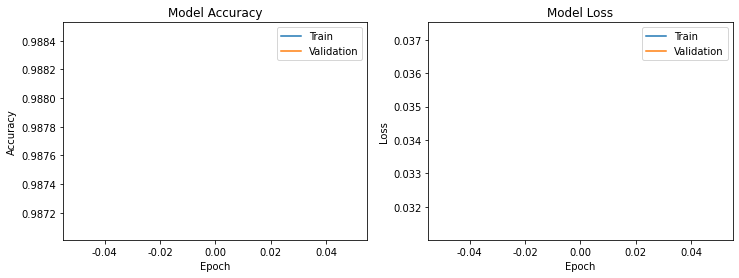

In [53]:
plot_metrics(lstm_history)

findfont: Font family ['NanumGothinc'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumGothinc'] not found. Falling back to DejaVu Sans.


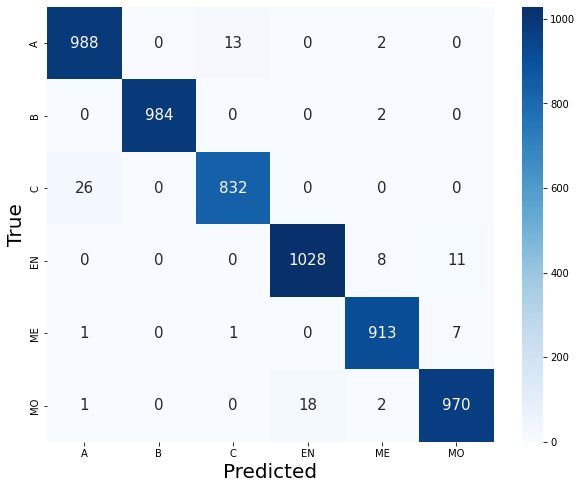

In [54]:
# confusion matrix 계산
cm = confusion_matrix(y_true=true_list, y_pred=pred_list)
cm_df = pd.DataFrame(cm)

cm_df.index = encoder.classes_
cm_df.columns = encoder.classes_

# confusion matrix 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(data=cm_df, annot=True, fmt='d', annot_kws={'size': 15}, cmap='Blues')
plt.xlabel('Predicted', size=20)
plt.ylabel('True', size=20)
plt.show()

In [55]:
df_test = create_experiment_number(df_test)
df_test.head()

,C7H8,TMA,VOC,CO2,HCHO,H2S,NH3,CH3SH,SO2,NO2,CO,reg_date,label_type,exp_num
0,0.033189,0.000070,0.511069,100.79880,0.0,0.206896,0.618528,0.0,0.0,0.016224,1.322998,2023-04-03 13:20:34,ME,0.0
1,0.045531,0.000076,0.550266,169.63690,0.0,0.319673,1.126904,0.0,0.0,0.008808,1.365734,2023-04-03 13:20:36,ME,0.0
2,0.060589,0.000080,0.549399,99.92882,0.0,0.450816,1.672414,0.0,0.0,0.002323,1.347419,2023-04-03 13:20:37,ME,0.0
3,0.076748,0.000082,0.550266,70.44612,0.0,0.579394,2.248468,0.0,0.0,0.000000,1.359628,2023-04-03 13:20:39,ME,0.0
4,0.091999,0.000083,0.550266,60.61852,0.0,0.692952,2.811248,0.0,0.0,0.000000,1.310788,2023-04-03 13:20:40,ME,0.0


In [56]:
# Test Dataloader 구축
# data shape: (batch_size x input_size x seq_len) => (32, 11, 5)
real_test_dataloader = create_test_dataset(df_test, window_size, batch_size, encoder=encoder, scaler=scaler)

In [57]:
r_pred_list, r_true_list = test_model(lstm, real_test_dataloader)

Testing Acc: 0.6574


In [58]:
encoding_numbers = list(range(0,len(encoder.classes_)))
label_dict = dict(zip(encoding_numbers, encoder.inverse_transform(encoding_numbers)))
print(label_dict)

{0: 'A', 1: 'B', 2: 'C', 3: 'EN', 4: 'ME', 5: 'MO'}


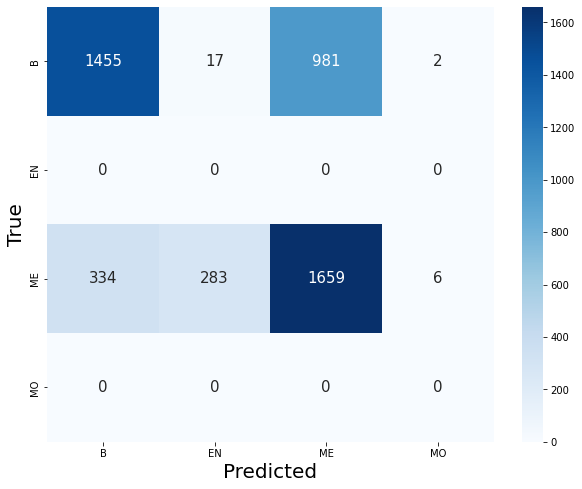

In [59]:
# confusion matrix 계산
cm = confusion_matrix(y_true=r_true_list, y_pred=r_pred_list)
cm_df = pd.DataFrame(cm, columns=np.unique(r_pred_list), index=np.unique(r_pred_list))

new_index = [label_dict[i] for i in cm_df.index]
new_columns = [label_dict[i] for i in cm_df.columns]

# 인덱스와 컬럼 이름 변경
cm_df = cm_df.rename(index=dict(zip(cm_df.index, new_index)), columns=dict(zip(cm_df.columns, new_columns)))

# confusion matrix 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(data=cm_df, annot=True, fmt='d', annot_kws={'size': 15}, cmap='Blues')
plt.xlabel('Predicted', size=20)
plt.ylabel('True', size=20)
plt.show()